<h2>Baixando Bibliotecas</h2>
Neste projeto usamos os seguintes pacotes:
<ul>
    Para Executar modelo
    <li>
        torch==2.4.1        
    </li>
    <li>
        triton==3.0.0
    </li>
    <li>
        transformers==4.46.3
    </li>
    <li>
        safetensors==0.4.5
    </li>
        <li>
        torch==2.4.1        
    </li>
    <li>
        accelerate>=0.26.0
    </li>
    <br>
    Para criar interface
    <li>
        chainlit
    </li>
</ul>

Para instala-los, basta ir pelo terminal até a pasta raiz, e executar:


pip install -r requirements.txt



<h2>Baixando Modelo</h2>
O modelo em questão está disponibilizado gratuitamente no site huggingface: 

$\;\;\;\;\;\;$ https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat

Para Baixa-lo, é necessário abrir no terminal a pasta destino e executar:

$\;\;\;\;\;\;$ git clone https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat 

Também precisamos extrair os binarios desses arquivo para isso precisamos:
<ul>
    <li>
        Instalar o git-lfs
    </li>
    $\;\;\;\;\;\;$ sudo apt install git-lfs
    <br>
    <li>
        Executar o comando dentro da pasta gerada
    </li>
    $\;\;\;\;\;\;$ cd deepseek-llm-7b-chat
    <br>
    $\;\;\;\;\;\;$ git lfs install
    <br>
    $\;\;\;\;\;\;$ git lfs pull
</ul>

<h2> Importando e carregando</h2>
Como já baixamos o modelo, para executa-lo, basta colocar na variável model_name o caminho até a pasta com os binários.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
#definimos onde está o modelo
model_name = "./DeepSeek-V3/deepseek-llm-7b-chat"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)#, device_map="auto")
model.generation_config = GenerationConfig.from_pretrained(model_name)
model.generation_config.pad_token_id = model.generation_config.eos_token_id

<h2>Executando</h2>
Agora já podemos testar! Abaixo temos um exemplo de pergunta "Who are you?" em que esperamos uma resposta do modelo.

<strong>Atenção:</strong> a depender da máquina, até a resposta chegar pode demorar bastente(no meu core i3 de 6 geração demorou ~6 min). 
Caso esse tempo sejá muito grande, recomendo trocar de modelo

In [ ]:
messages = [
    {"role": "user", "content": "Who are you?"}
]
input_tensor = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
outputs = model.generate(input_tensor.to(model.device), max_new_tokens=100,pad_token_id = tokenizer.eos_token_id,)

result = tokenizer.decode(outputs[0][input_tensor.shape[1]:], skip_special_tokens=True)
print(result)

<h3>Generalizando</h3>
Após esse teste bem sucedido, vamos criar função que recebe um input, e gera resposta do modelo baseada nesse input.


In [ ]:
from typing import List

#inicio o historico de conversas marcando qual o prompt do sistema que irá usar sempre. Cuidado, cada modelo tem um padrão.
historico_conversas = [
    {
        "role":"system",
        "content": "You are an AI assistante that gives helpful answers on a cordial way. You must answer the questions in a short and consice way"
    }
]

def PegoResposta(entrada:str) -> str:
    #adiciono historico até o momento
    global historico_conversas
    historico_conversas.append({"role": "user", "content":entrada})

    #aplico template de chat na entrada, e retorno valor em tokens
    inputs = tokenizer.apply_chat_template(
        historico_conversas, #carrego entradas, no caso é o padrão dos sistema  + historico + input do usuario
        add_generation_prompt=True,#adiciono no começo um token indicando que espero a respsota do modelo
        return_tensors="pt" #quando tokenizo entradas, essas entradas estão no formato de tensores do pytorch
        ).to(model.device)

    #solicito resposta, atenção, ela vem como sequência de tokens!
    outputs = model.generate(
        inputs,
        pad_token_id = tokenizer.eos_token_id,
        max_new_tokens=100, #limito a resposta a no máximo 100 tokens(padrão 256). Para ser consiso use etnre 50 e 100. Para criatividade, usae entre 200-500.
        do_sample=True, #deixe como False para pegar sempre o token mais provável, se true iremos definir como escolher o próximo token
        temperature=0.4, #padrão 0.7. use valor entre 0.1 e 0.5 para leitura de textos, entre 0.5 e 1 para uma conversa descontraida e entre 1.2 e 2 para brincar. Aqui mudamos a probabilidade de todos os tokens
        top_p=0.2 #padrão 0.9 escolhemos que o próximo token seja baseado nos 90% tokens que mais fazem sentido. Entre 0.1 e 0.5 focamos a precisão. Entre 0.9 e 1 liberamos a criatividade. Aqui selecionamos os tokens mais prováveis
    )
    
    #decodifico resposta, ou seja, transformo a sequência de valores de tokens, em uma sequência de strings
    resposta = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    #adiciono respsota ao historico
    historico_conversas.append({"role": "assistant", "content": response})

    return resposta

<h2>Criando Interface</h2>
Para nossa interface, iremos usar o ChainLit. Ele é bem leve e gera um link para o navegador.
<br>
Ele consiste em alguns métodos:
<ul>
    <li>
     "on_chat_start" serve para executarmos um script quando iniciarmos o chatbot
    </li>
    <li>
    "on_message" realiza uma ação toda vez que o chatbot receber uma resposta
    </li>
</ul>

In [ ]:
import chainlit as cl

@cl.on_chat_start
async def start_chat():
    await cl.Message(resposta = await cl.make_async(PegoResposta)(entrada)
        content="Ola, sou seu ChatBot que usa a inteligência do DeepSeek. Em que posso ajudar?"
    ).send()

@cl.on_message
async def main(message: cl.Message):
    # Leio entrada do usuário
    entrada = message.content
    # Aviso que estou pensando
    await cl.Message(
        content=f"Entendi que você me mandou: {entrada} \n Estou pensando em como te responder..."
    ).send()
    start = timeit.timeit()
    # Busco resposta do chatbot a essa entrada. É bom deixar como assincrono pois a busca de uma resposta pode demorar alguns minutos...
    resposta = await cl.make_async(PegoResposta)(entrada)
    # Envio resposta de volta
    await cl.Message(
        content=resposta
    ).send()

<h2>Visualizando Interface</h2>
Para visualizar o nosso teste, precisamos executar o seguinte comando no terminal:
<br>
$\;\;\;\;\;\;$chainlit run chatbot.py -w --port 8080 --host 0.0.0.0
<br>
É interessante notar que para modificar o chainlit, baste mexer nos arquivos:
<ul>
    <li>
        "chainlit.md" onde está a descrição de tudo que está no README
    </li>
</ul>

Inserir print de conversa

<h2>Fazendo Deploy</h2>
Para realizar o deploy iremos utilizar o ngrok. Ele é um programa para que você consiga fazer que seus sites locais possam ser acessados por toda a internet.
<h4>Instalando</h4>
Para instalar na sua máquina (linux) basta executar:
$\;\;\;\;\;\;$ sudo snap install ngrok
<h4>Arrumando ambiente</h4>
Para utiliza-lo, é necessário:

- Fazer uma conta gratuita em: https://dashboard.ngrok.com/signup
        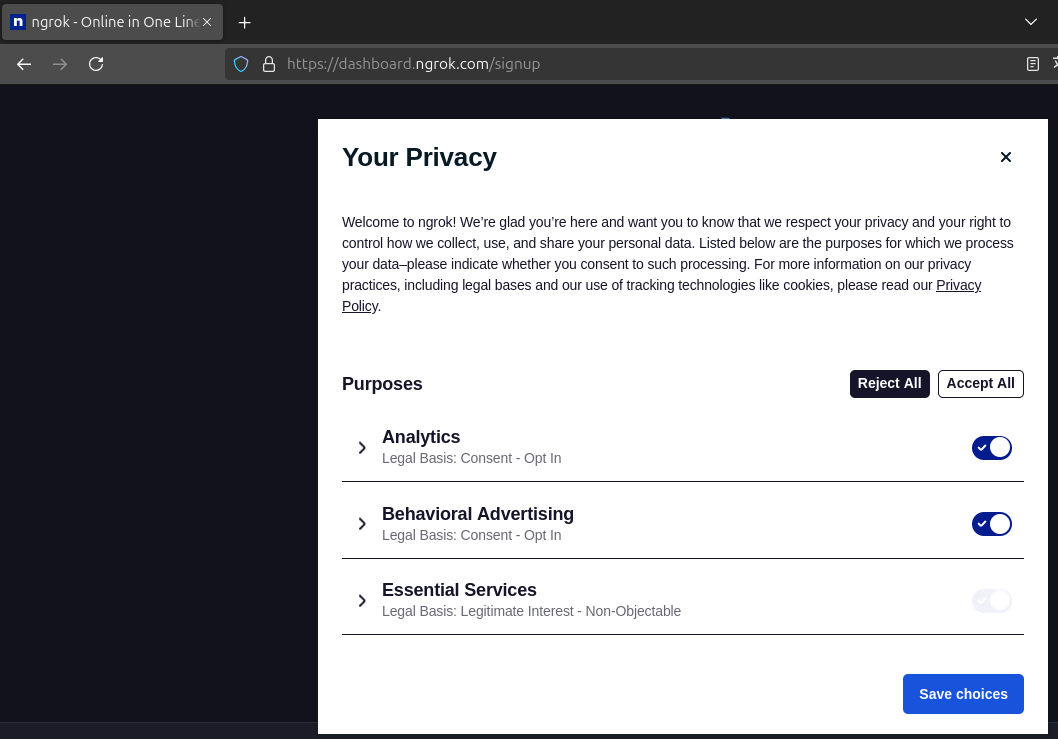
        

- Encontrar seu token de autenticação:
        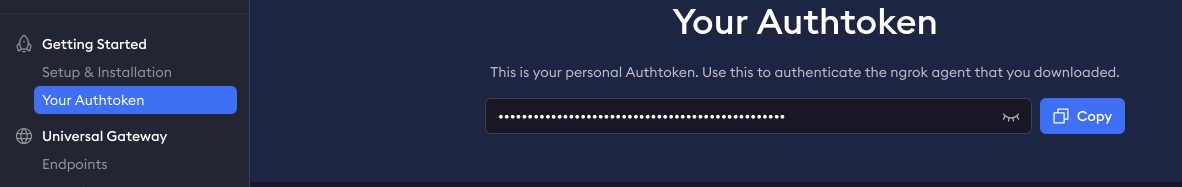

- Salvar ele em seu terminal: 
        $\;\;\;\;\;\;$ ngrok config add-authtoken ColoqueSeuTokenDeAutenticaçãoAqui

<h4>Fazendo rodar</h4>
Agora que temos o ambiente ok, vamos inserir nosso site na web!

- Inicie executando o Chainlit
         $\;\;\;\;\;\;$chainlit run chatbot.py -w --port 8080 --host 0.0.0.0
        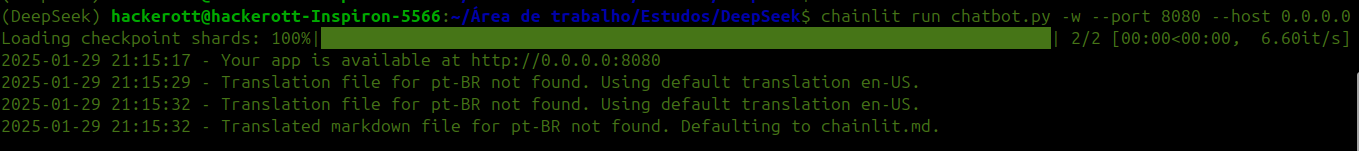
- Execute o ngrok com a mesma saida do Chailit
        $\;\;\;\;\;\;$ngrok http http://0.0.0.0:8080/
        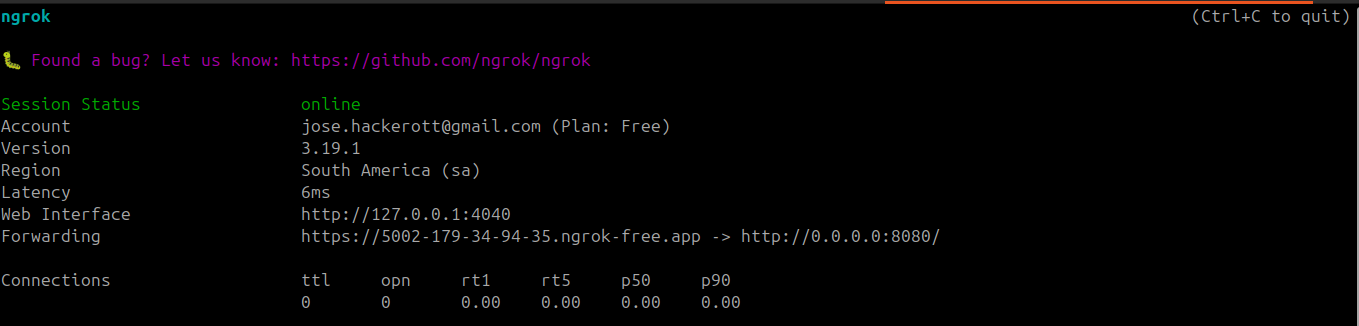
<h4>Aproveite!</h4>
Para rodar o site, basta buscar o link na tela que está no forwarding!

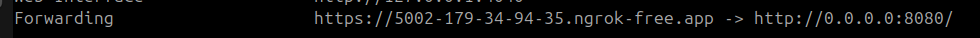

Entre nesse site
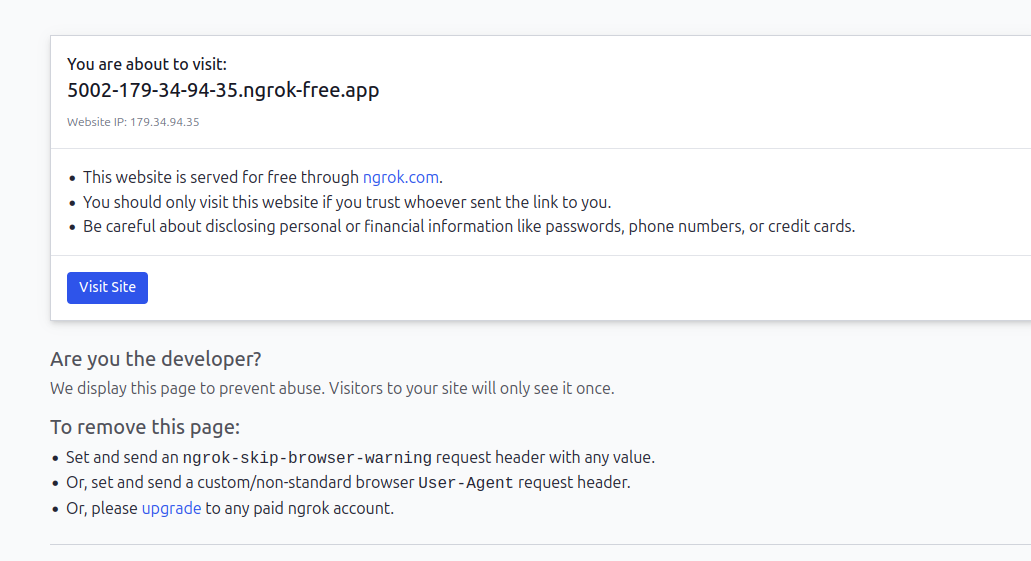

E sinta-se a vontade para usar seu chatbot!
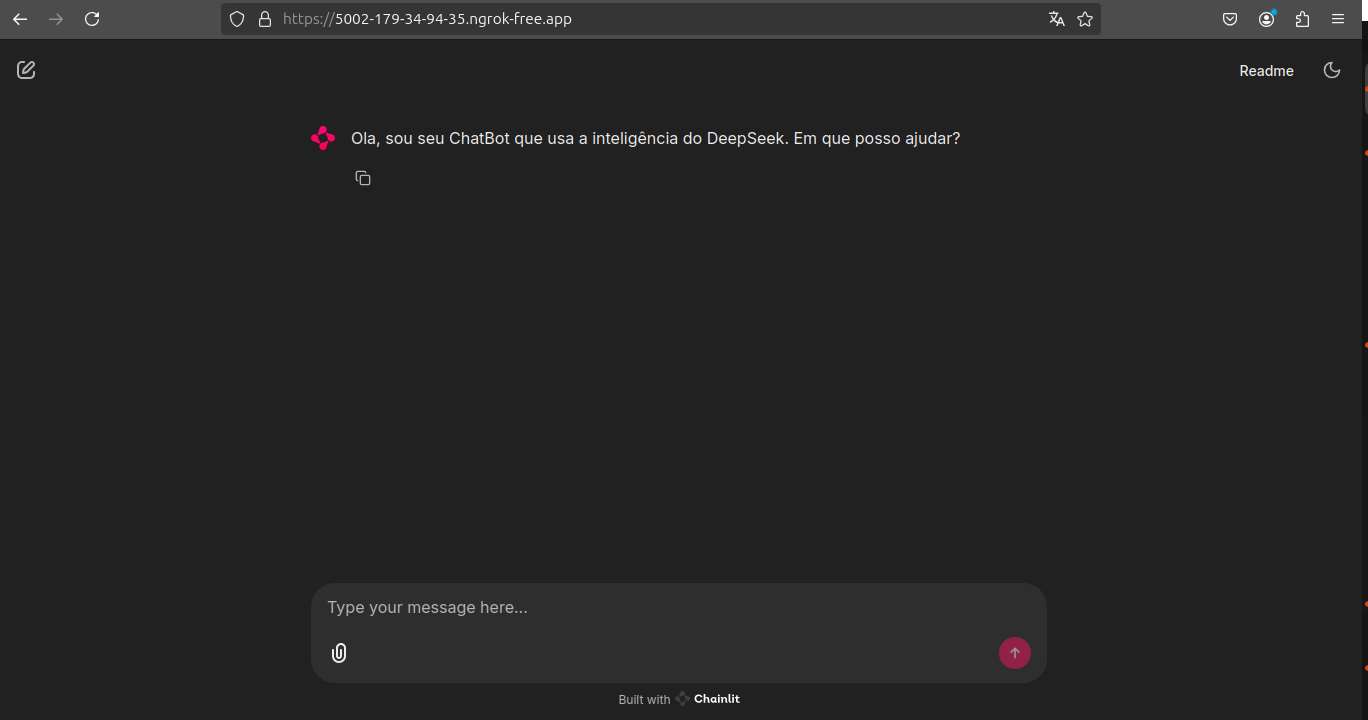

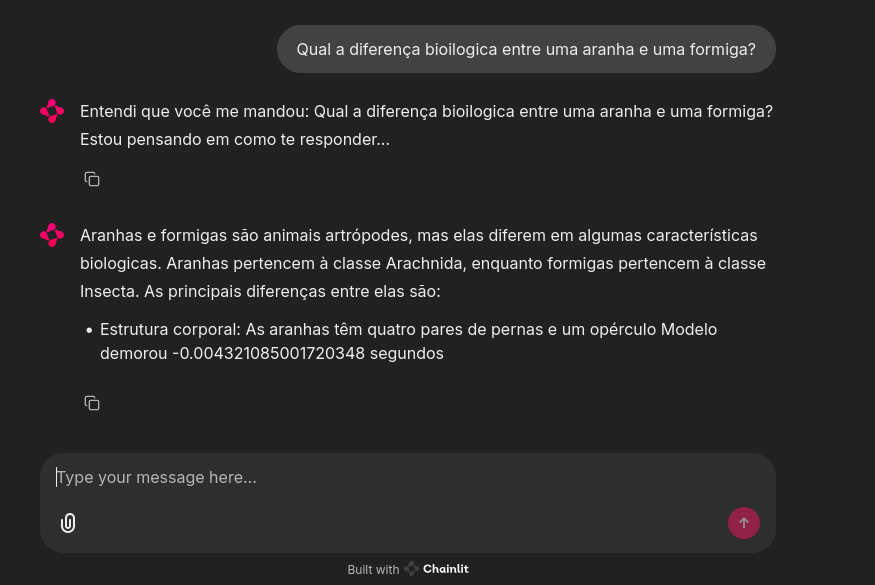